# Imports 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)        # No truncar el ancho de la tabla
pd.set_option('display.max_rows', None)     
pd.set_option('display.float_format', '{:.4f}'.format)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math

In [2]:
player_stats = pd.read_csv('../data/player_stats.csv')
match_events = pd.read_csv('../data/match_event_base.csv')
shots_events = pd.read_csv('../data/shot_events.csv')
card_events = pd.read_csv('../data/card_events.csv')
match_stats = pd.read_csv('../data/norm_matches.csv')
rounds = pd.read_csv('../data/matches.csv')
players = pd.read_csv('../data/players.csv', encoding='utf-8')


In [3]:
player_stats.head()

,player_match_stat_id,match_id,player_id,team_id,is_substitute,played_position,jersey_number,market_value_eur_at_match,sofascore_rating,minutes_played,touches,goals,assists,own_goals,passes_accurate,passes_total,passes_key,long_balls_accurate,long_balls_total,crosses_accurate,crosses_total,shots_total,shots_on_target,shots_off_target,shots_blocked_by_opponent,dribbles_successful,dribbles_attempts,possession_lost,dispossessed,duels_won,duels_lost,aerials_won,aerials_lost,ground_duels_won,ground_duels_total,tackles,interceptions,clearances,shots_blocked_by_player,dribbled_past,fouls_committed,fouls_suffered,saves,punches_made,high_claims,saves_inside_box,sweeper_keeper_successful,sweeper_keeper_total,goals_prevented,runs_out_successful,penalties_saved,penalty_committed,expected_goals,expected_assists,penalty_won,penalty_miss,big_chances_missed,errors_leading_to_shot,big_chances_created,errors_leading_to_goal
0,1,11352250,84844,60,f,G,1,1900000.0000,6.4000,90,46,0,0,0,27,39,0,6,18,0,0,0,0,0,0,0,0,12,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,-0.2972,0,0,0,0.0000,0.0053,0,0,0,0,0,0
1,2,11352250,943645,60,f,D,37,11600000.0000,6.9000,75,52,0,0,0,32,36,1,1,1,0,1,0,0,0,0,0,0,6,0,6,6,0,3,0,3,2,0,0,0,1,1,2,0,0,0,0,0,0,NaN,0,0,0,0.0000,0.0691,0,0,0,0,0,0
2,3,11352250,1023567,60,f,D,27,37000000.0000,6.5000,90,102,0,0,0,77,96,0,4,15,0,0,0,0,0,0,0,0,20,0,5,8,4,5,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,NaN,0,0,0,0.0000,0.0122,0,0,0,0,0,0
3,4,11352250,830659,60,f,D,25,22000000.0000,6.7000,60,62,0,0,0,43,51,0,3,8,0,0,0,0,0,0,0,0,10,1,3,6,1,2,2,0,2,1,3,1,2,1,0,0,0,0,0,0,0,NaN,0,0,0,0.0000,0.0172,0,0,0,0,0,0
4,5,11352250,1097425,60,f,D,3,36000000.0000,6.8000,90,75,0,0,0,31,40,1,2,3,1,4,0,0,0,0,0,0,17,1,10,6,4,2,6,3,2,0,3,0,1,0,3,0,0,0,0,0,0,NaN,0,0,0,0.0000,0.0493,0,0,0,0,0,0


As we can see Theres tons of players without a rating. This is due to the fact that the script is scrapping all players of each team including the ones that didnt played a single minute. In this case we will drop them.

Now lets check the data of the games overall. We will be looking at the stats on the full game.

# Filtering for only full time stats

In [4]:
match_stats_full = match_stats.loc[match_stats['period'] == 'ALL']
print(len(match_stats_full))

7378


In [5]:
match_stats_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7378 entries, 0 to 22129
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   team_match_stat_id           7378 non-null   int64  
 1   match_id                     7378 non-null   int64  
 2   team_id                      7378 non-null   int64  
 3   opp_team_id                  7378 non-null   int64  
 4   home_away                    7378 non-null   object 
 5   period                       7378 non-null   object 
 6   formation                    7376 non-null   object 
 7   average_team_rating          7376 non-null   float64
 8   total_team_market_value_eur  7376 non-null   float64
 9   possession_percentage        7378 non-null   float64
 10  big_chances                  7378 non-null   int64  
 11  total_shots                  7378 non-null   int64  
 12  saves                        7378 non-null   int64  
 13  corners               

# Events: Cards + Shots

In [6]:
match_events.head()

,event_id,match_id,minute,event_type,team_id,player_id
0,1,11352250,90,card,60,865740.0000
1,2,11352250,90,substitution,37,839981.0000
2,3,11352250,90,card,37,839981.0000
3,4,11352250,87,card,37,155997.0000
4,5,11352250,86,substitution,37,816763.0000


In [7]:
shots_events.head()

,event_id,shooter_player_id,shot_outcome,situation,body_part,xg,xgot,player_coord_x,player_coord_y,goal_mouth_location,goal_mouth_coord_x,goal_mouth_coord_y,goal_mouth_coord_z,block_coord_x,block_coord_y,goalkeeper_id,added_time
0,16,934354,block,assisted,left-foot,0.0193,NaN,27.5000,57.3000,low-centre,0,50.4000,19.0000,17.0000,54.3000,NaN,NaN
1,17,839981,post,regular,left-foot,0.0642,NaN,13.5000,36.0000,left,0,55.2000,6.3000,NaN,NaN,NaN,NaN
2,18,130181,block,assisted,right-foot,0.1237,NaN,12.0000,64.5000,low-right,0,48.0000,19.0000,7.6000,59.9000,NaN,NaN
3,19,361420,goal,regular,right-foot,0.8712,0.9686,3.5000,54.9000,low-right,0,47.7000,2.5000,NaN,NaN,NaN,NaN
4,20,934354,miss,regular,right-foot,0.0543,NaN,21.7000,62.9000,left,0,66.7000,15.3000,14.2000,52.3000,NaN,NaN


In [8]:
card_events.head()

,event_id,card_type,reason,is_rescinded
0,1,yellow,Argument,f
1,3,yellow,Persistent fouling,f
2,4,yellow,Foul,f
3,14,yellow,Foul,f
4,15,yellow,Argument,f


In [9]:
only_shots_events = match_events.loc[(match_events['event_type'] == 'shot')]

#Goals are presented in shot events also...
shot_events_per_match = pd.merge(only_shots_events, shots_events, on='event_id', how = 'left')
shot_events_per_match.head()

,event_id,match_id,minute,event_type,team_id,player_id,shooter_player_id,shot_outcome,situation,body_part,xg,xgot,player_coord_x,player_coord_y,goal_mouth_location,goal_mouth_coord_x,goal_mouth_coord_y,goal_mouth_coord_z,block_coord_x,block_coord_y,goalkeeper_id,added_time
0,16,11352250,89,shot,60,934354.0000,934354,block,assisted,left-foot,0.0193,NaN,27.5000,57.3000,low-centre,0,50.4000,19.0000,17.0000,54.3000,NaN,NaN
1,17,11352250,85,shot,37,839981.0000,839981,post,regular,left-foot,0.0642,NaN,13.5000,36.0000,left,0,55.2000,6.3000,NaN,NaN,NaN,NaN
2,18,11352250,84,shot,37,130181.0000,130181,block,assisted,right-foot,0.1237,NaN,12.0000,64.5000,low-right,0,48.0000,19.0000,7.6000,59.9000,NaN,NaN
3,19,11352250,82,shot,60,361420.0000,361420,goal,regular,right-foot,0.8712,0.9686,3.5000,54.9000,low-right,0,47.7000,2.5000,NaN,NaN,NaN,NaN
4,20,11352250,82,shot,60,934354.0000,934354,miss,regular,right-foot,0.0543,NaN,21.7000,62.9000,left,0,66.7000,15.3000,14.2000,52.3000,NaN,NaN


Now the interesting thing will be to find how many shots where inside the area on target, by looking at the shot distance and outcome given by (player_coord_x and shot_outcome(goal or saved)) in every match. We will use these stats to evaluate about 80% the performance of the goalkeeper.



In [10]:
#corner goals
goals_due_to_corner = shot_events_per_match[
    (shot_events_per_match['situation'] == 'corner') & (shot_events_per_match['shot_outcome'] == 'goal')
]
goals_due_to_corner_per_game = goals_due_to_corner.groupby(['match_id', 'team_id']).size().reset_index(name = 'goals_due_to_corner')

# What about mapping each sector of the field to a limiter area

The idea is to define a limited area, based on rectangles to map every shot. Then with all the data we will learn how many goals there is in every sector. After that we will stablish how important its a goal there, how important a save and a block.

The settings of the field are given by: X, the length and Y the wide.

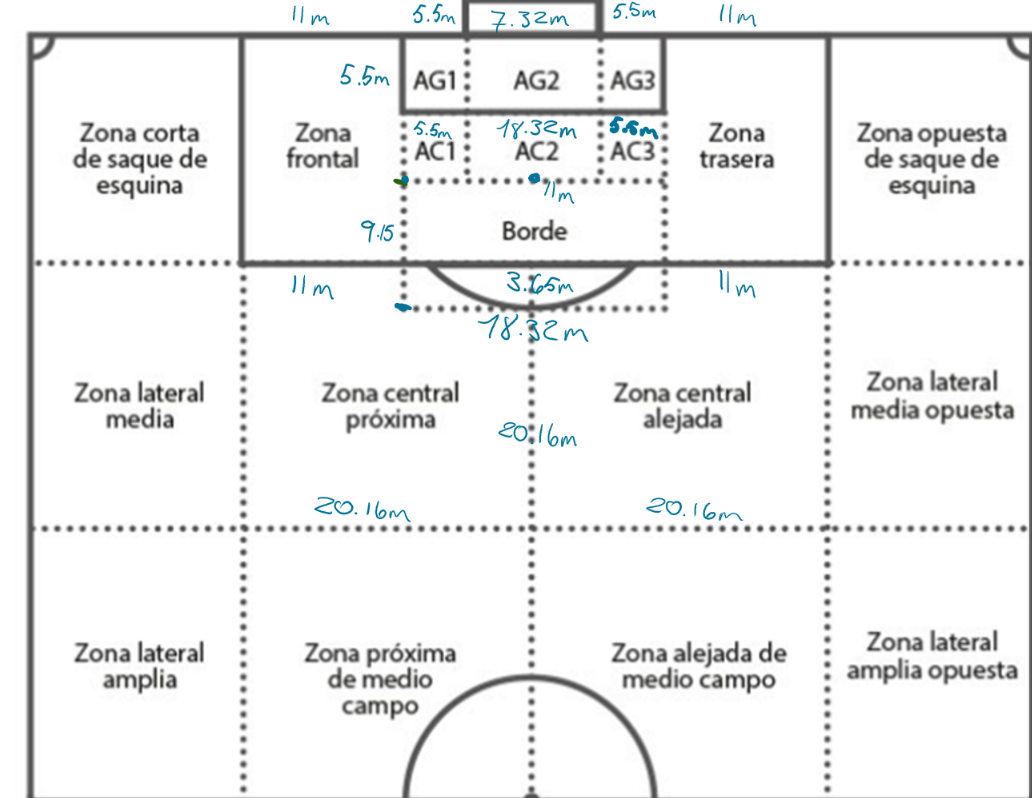


In [11]:
def map_shot_to_area(df):

    
    X_LINEA_FONDO = 0.0
    X_LINEA_GK_AREA = 5.5
    X_TOPE_PUNTO_PENAL = 11
    X_TOPE_AREA_GRANDE = 16.5
    X_TOPE_SEMI_LUNA = 20.15
    X_TOPE_ZCP = 36.66 #Lim of Zona Central Proxima and Zona Central Alejada

    #In order to find the value of Y width we need to find the val of the penalty point which is the middle point of the Y axis, 
    # so if we multiply by 2 we get the full length of the field.

    Y_PENALTY_POINT = 50

    Y_LIM_L_AG2 = Y_PENALTY_POINT - 3.66
    Y_LIM_L_AG1 = Y_LIM_L_AG2 - 5.5
    Y_LIM_AREA_GRANDE_L = Y_LIM_L_AG1 - 11
    LIM_FIELD_L = 0

    
    Y_LIM_R_AG2 = Y_PENALTY_POINT + 3.66
    Y_LIM_R_AC3 = Y_LIM_R_AG2 + 5.5
    Y_LIM_AREA_GRANDE_R = Y_LIM_R_AC3 + 11
    LIM_FIELD_R = 100

    x = df['player_coord_x']
    y = df['player_coord_y']

    #========================================================================================
    conditions = []
    values = []

    #Zona corte de esquina
    mask_zona_corta_esquina_L = (x >= X_LINEA_FONDO) & (x < X_TOPE_AREA_GRANDE) & (y < Y_LIM_AREA_GRANDE_L)
    conditions.append(mask_zona_corta_esquina_L)
    values.append('FL1')

    #Zona frontal area
    mask_zona_frontal = (x >= X_LINEA_FONDO) & (x < X_TOPE_AREA_GRANDE) & (y >= Y_LIM_AREA_GRANDE_L) & (y < Y_LIM_L_AG1)
    conditions.append(mask_zona_frontal)
    values.append('FL2')

    mask_x1 = (x >= X_LINEA_FONDO) & (x < X_LINEA_GK_AREA)
    conditions.append(mask_x1 & (y >= Y_LIM_L_AG1) & (y <  Y_LIM_L_AG2))
    values.append('AG1')
    conditions.append(mask_x1 & (y >= Y_LIM_L_AG2) & (y <=  Y_LIM_R_AG2))
    values.append('AG2')
    conditions.append(mask_x1 & (y > Y_LIM_R_AG2) & (y <= Y_LIM_R_AC3))
    values.append('AG3')

    mask_x2 = (x >= X_LINEA_GK_AREA) & (x < X_TOPE_PUNTO_PENAL)
    conditions.append(mask_x2 & (y >= Y_LIM_L_AG1) & (y <  Y_LIM_L_AG2))
    values.append('AC1')
    conditions.append(mask_x2 & (y >= Y_LIM_L_AG2) & (y <=  Y_LIM_R_AG2))
    values.append('AC2')
    conditions.append(mask_x2 & (y > Y_LIM_R_AG2) & (y <= Y_LIM_R_AC3))
    values.append('AC3')

    mask_zona_trasera = (x >= X_LINEA_FONDO) & (x < X_TOPE_AREA_GRANDE) & (y > Y_LIM_R_AC3) & (y <= Y_LIM_AREA_GRANDE_R)
    conditions.append(mask_zona_trasera)
    values.append('FL3')


    mask_zona_corta_esquina_R = (x >= X_LINEA_FONDO) & (x < X_TOPE_AREA_GRANDE) & (y > Y_LIM_AREA_GRANDE_R) 
    conditions.append(mask_zona_corta_esquina_R)
    values.append('FL4')

    mask_x4 = (x >= X_TOPE_PUNTO_PENAL) & (x < X_TOPE_AREA_GRANDE) & (y > Y_LIM_L_AG1) & (y < Y_LIM_R_AC3) & (df['situation'] != 'penalty')
    conditions.append(mask_x4)
    values.append('B1')

    #====================================================================================================================
    mask_xx5 = (x >= X_TOPE_AREA_GRANDE) & (x < X_TOPE_SEMI_LUNA) & (y >= Y_LIM_AREA_GRANDE_L) & (y <= Y_PENALTY_POINT)
    mask_xxx5 = (x >= X_TOPE_AREA_GRANDE) & (x < X_TOPE_SEMI_LUNA) & (y > Y_PENALTY_POINT) & (y <= Y_LIM_AREA_GRANDE_R)
    conditions.append(mask_xx5)
    values.append('B2') 
    conditions.append(mask_xxx5)
    values.append('B3')


    #=====================================================================================================================
    mask_x5 = (x >= X_TOPE_SEMI_LUNA) & (x < X_TOPE_ZCP)
    conditions.append(mask_x5 & (y >= 0) & (y <= Y_LIM_AREA_GRANDE_L))
    values.append('YF1')
    conditions.append(mask_x5 & (y >  Y_LIM_AREA_GRANDE_L) & (y <  Y_PENALTY_POINT))
    values.append('YF2')
    conditions.append(mask_x5 & (y >= Y_PENALTY_POINT)   & (y <=  Y_LIM_AREA_GRANDE_R))
    values.append('YF3')
    conditions.append(mask_x5 & (y > Y_LIM_AREA_GRANDE_R) & (y <= 100))
    values.append('YF4')

    mask_x6 = x >= X_TOPE_ZCP
    conditions.append(mask_x6 & (y >= 0)                & (y <= Y_LIM_AREA_GRANDE_L))
    values.append('ZF1')
    conditions.append(mask_x6 & (y >  Y_LIM_AREA_GRANDE_L) & (y <  Y_PENALTY_POINT))
    values.append('ZF2')
    conditions.append(mask_x6 & (y >= Y_PENALTY_POINT) & (y <  Y_LIM_AREA_GRANDE_R))
    values.append('ZF3')
    conditions.append(mask_x6 & (y >= Y_LIM_AREA_GRANDE_R))
    values.append('ZF4')

    conditions.append(df['situation'] == 'penalty')
    values.append('penalty')

    df['shot_zone'] = np.select(conditions, values, default='sin_zona')

    df = df[df['shot_zone'] != 'penalty']

    return df



shots_events_per_match_mapped = map_shot_to_area(shot_events_per_match)
shots_events_per_match_mapped.head()

,event_id,match_id,minute,event_type,team_id,player_id,shooter_player_id,shot_outcome,situation,body_part,xg,xgot,player_coord_x,player_coord_y,goal_mouth_location,goal_mouth_coord_x,goal_mouth_coord_y,goal_mouth_coord_z,block_coord_x,block_coord_y,goalkeeper_id,added_time,shot_zone
0,16,11352250,89,shot,60,934354.0000,934354,block,assisted,left-foot,0.0193,NaN,27.5000,57.3000,low-centre,0,50.4000,19.0000,17.0000,54.3000,NaN,NaN,YF3
1,17,11352250,85,shot,37,839981.0000,839981,post,regular,left-foot,0.0642,NaN,13.5000,36.0000,left,0,55.2000,6.3000,NaN,NaN,NaN,NaN,FL2
2,18,11352250,84,shot,37,130181.0000,130181,block,assisted,right-foot,0.1237,NaN,12.0000,64.5000,low-right,0,48.0000,19.0000,7.6000,59.9000,NaN,NaN,FL3
3,19,11352250,82,shot,60,361420.0000,361420,goal,regular,right-foot,0.8712,0.9686,3.5000,54.9000,low-right,0,47.7000,2.5000,NaN,NaN,NaN,NaN,AG3
4,20,11352250,82,shot,60,934354.0000,934354,miss,regular,right-foot,0.0543,NaN,21.7000,62.9000,left,0,66.7000,15.3000,14.2000,52.3000,NaN,NaN,YF3


In [12]:
#id_game = shots_events_per_match_mapped.loc[shots_events_per_match_mapped['match_id'] == 12436596]
#id_game[['minute', 'event_type', 'team_id', 'player_coord_x', 'player_coord_y', 'shot_zone']].sort_values(by = 'minute')

In [13]:
print(shots_events_per_match_mapped['shot_zone'].value_counts())

shot_zone
FL2         11067
B1          10538
FL3         10342
YF2          9867
YF3          9553
AC2          7510
AC1          4150
B2           4077
AC3          4012
B3           3980
AG2          2494
FL1          2461
FL4          2105
AG1          1709
YF1          1569
AG3          1519
YF4          1248
sin_zona     1157
ZF2           144
ZF3           125
ZF1            83
ZF4            82
Name: count, dtype: int64


In [14]:
#Lets do some aggregations in order to investigate the efficiency of the shots made.
shots_converted_goal = shots_events_per_match_mapped[
    shots_events_per_match_mapped['shot_outcome'] == 'goal'
]
shots_saved = shots_events_per_match_mapped[
    shots_events_per_match_mapped['shot_outcome'] == 'save'
]

shots_blocked = shots_events_per_match_mapped[
    shots_events_per_match_mapped['shot_outcome'] == 'block'
]

shots_on_target = shots_events_per_match_mapped[(
    shots_events_per_match_mapped['shot_outcome'] == 'goal') |
    (shots_events_per_match_mapped['shot_outcome'] == 'save')
]


shots_per_zone = shots_events_per_match_mapped.groupby('shot_zone').size().reset_index(name = 'shots_per_zone')
goals_per_zone = shots_converted_goal.groupby('shot_zone').size().reset_index(name = 'goals_per_zone')
saves_per_zone = shots_saved.groupby('shot_zone').size().reset_index(name = 'shots_saves_per_zone')
blocks_per_zone = shots_blocked.groupby('shot_zone').size().reset_index(name = 'shots_blocked_per_zone')
shot_on_target_per_zone = shots_on_target.groupby('shot_zone').size().reset_index(name = 'shots_on_target_per_zone')


area_stats = pd.DataFrame()
area_stats['shot_zone'] = shots_per_zone['shot_zone']
area_stats['shots_per_zone'] = shots_per_zone['shots_per_zone']
area_stats['goals_per_zone'] = goals_per_zone['goals_per_zone']
area_stats['ratio_goals_shot_per_zone'] = area_stats['goals_per_zone'] / area_stats['shots_per_zone']
total_goals = area_stats['goals_per_zone'].sum()
area_stats['ratio_goals_zone'] = area_stats['goals_per_zone'] / total_goals
area_stats['shots_saves_per_zone'] = saves_per_zone['shots_saves_per_zone']
area_stats['blocks_per_zone'] = blocks_per_zone['shots_blocked_per_zone']

area_stats['ratio_saves'] = area_stats['shots_saves_per_zone'] / area_stats['shots_per_zone']
area_stats['ratio_blocks'] = area_stats['blocks_per_zone'] / area_stats['shots_per_zone']
area_stats['shots_on_target_per_zone'] = shot_on_target_per_zone['shots_on_target_per_zone']

area_stats['ratio_goal_shot_on_t_per_zone'] = area_stats['goals_per_zone'] / area_stats['shots_on_target_per_zone']
area_stats


,shot_zone,shots_per_zone,goals_per_zone,ratio_goals_shot_per_zone,ratio_goals_zone,shots_saves_per_zone,blocks_per_zone,ratio_saves,ratio_blocks,shots_on_target_per_zone,ratio_goal_shot_on_t_per_zone
0,AC1,4150,610,0.1470,0.0665,924,719,0.2227,0.1733,1534,0.3977
1,AC2,7510,1403,0.1868,0.1530,1586,1071,0.2112,0.1426,2989,0.4694
2,AC3,4012,621,0.1548,0.0677,812,736,0.2024,0.1834,1433,0.4334
3,AG1,1709,442,0.2586,0.0482,315,216,0.1843,0.1264,757,0.5839
4,AG2,2494,1242,0.4980,0.1354,388,220,0.1556,0.0882,1630,0.7620
5,AG3,1519,367,0.2416,0.0400,322,213,0.2120,0.1402,689,0.5327
6,B1,10538,1240,0.1177,0.1352,2355,3092,0.2235,0.2934,3595,0.3449
7,B2,4077,255,0.0625,0.0278,896,1485,0.2198,0.3642,1151,0.2215
8,B3,3980,280,0.0704,0.0305,803,1523,0.2018,0.3827,1083,0.2585
9,FL1,2461,63,0.0256,0.0069,763,753,0.3100,0.3060,826,0.0763


Now we will be calculating the performance of the goalkeeper in the match. To be able to do this calculation its important to following these steps.
I. Separating match_stats_full for home_teams and visit_teams, this is due to the fact that the performance of a goalkeeper is based on the shot quality of enemy team.
II. We will group every shot by match & team to calculate the measure for each game individually
III. We will only take on account shots on target since we are evaluating the keeper performance and difficulty of the shots






In [15]:
shots_on_target_only = shots_events_per_match_mapped[
    (shots_events_per_match_mapped['shot_outcome'] == 'goal') | (shots_events_per_match_mapped['shot_outcome'] == 'save')
]


shots_on_target_only['was_goal'] = (shots_on_target_only['shot_outcome'] == 'goal').astype(int)

shots_on_target_only = shots_on_target_only.merge(
    area_stats[['shot_zone', 'ratio_goal_shot_on_t_per_zone']],
    on='shot_zone', how='left'
)

shots_on_target_only['performance_gk'] = (
    shots_on_target_only['ratio_goal_shot_on_t_per_zone'] - shots_on_target_only['was_goal']
)

performance_summary = (
    shots_on_target_only
    .groupby(['match_id', 'team_id'])
    .agg(
        performance_gk = ('performance_gk', 'sum'),
        num_shots_on_target=('performance_gk', 'count')
    )
    .reset_index()
    .rename(columns={'team_id': 'opp_team_id'})
)

performance_summary['avg_performance_gk_per_shot'] = performance_summary['performance_gk'] / performance_summary['num_shots_on_target']
local_stats = match_stats_full[match_stats_full['home_away'] == 'H'].copy()
visit_stats = match_stats_full[match_stats_full['home_away'] == 'A'].copy()


local_stats = local_stats.merge(
    performance_summary,
    on=['match_id', 'opp_team_id'],
    how='left'
)
visit_stats = visit_stats.merge(
    performance_summary,
    on=['match_id', 'opp_team_id'],
    how='left'
)

full_stats_with_perf = pd.concat([local_stats, visit_stats], ignore_index=True)

C:\Users\javie\AppData\Local\Temp\ipykernel_22400\2219023103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_on_target_only['was_goal'] = (shots_on_target_only['shot_outcome'] == 'goal').astype(int)


In [16]:
'''
#inside box
match_stats['shots_target_inside_box'] = shots_target_inside_box_per_game['shots_inside_box_on_target']
match_stats['shots_off_target_inside_box'] = shots_off_target_inside_box_per_game['shot_off_target_inside_box']
match_stats['shots_blocked_inside_box'] = shots_blocked_inside_box_per_game['shots_blocked_inside_box']
#outside box
match_stats['shots_target_outside_box'] = shots_target_outside_box_per_game['shots_target_outside_box']
match_stats['shots_off_target_outside_box'] = shots_off_target_outside_box_per_game['shots_off_target_outside_box']
match_stats['shots_blocked_outside_box'] = shots_blocked_outside_box_per_game['shots_blocked_outside_box']
#corner
match_stats['goals_due_to_corner'] = goals_due_to_corner_per_game['goals_due_to_corner']
'''

"\n#inside box\nmatch_stats['shots_target_inside_box'] = shots_target_inside_box_per_game['shots_inside_box_on_target']\nmatch_stats['shots_off_target_inside_box'] = shots_off_target_inside_box_per_game['shot_off_target_inside_box']\nmatch_stats['shots_blocked_inside_box'] = shots_blocked_inside_box_per_game['shots_blocked_inside_box']\n#outside box\nmatch_stats['shots_target_outside_box'] = shots_target_outside_box_per_game['shots_target_outside_box']\nmatch_stats['shots_off_target_outside_box'] = shots_off_target_outside_box_per_game['shots_off_target_outside_box']\nmatch_stats['shots_blocked_outside_box'] = shots_blocked_outside_box_per_game['shots_blocked_outside_box']\n#corner\nmatch_stats['goals_due_to_corner'] = goals_due_to_corner_per_game['goals_due_to_corner']\n"

In [17]:
only_card_events = match_events.loc[match_events['event_type'] == 'card']
card_events_per_match = pd.merge(only_card_events, card_events, on='event_id', how='left')
card_events_per_match.head()


,event_id,match_id,minute,event_type,team_id,player_id,card_type,reason,is_rescinded
0,1,11352250,90,card,60,865740.0000,yellow,Argument,f
1,3,11352250,90,card,37,839981.0000,yellow,Persistent fouling,f
2,4,11352250,87,card,37,155997.0000,yellow,Foul,f
3,14,11352250,49,card,37,47772.0000,yellow,Foul,f
4,15,11352250,39,card,37,552884.0000,yellow,Argument,f


In [18]:
yellow_cards = card_events_per_match[
    card_events_per_match['card_type'] == 'yellow'
]

red_cards = card_events_per_match[
    card_events_per_match['card_type'] == 'red'
]
yellow_cards_for_player_each_game = yellow_cards.groupby(['match_id', 'player_id']).size().reset_index(name = 'yellow_cards_count')
red_cards_for_player_each_game = red_cards.groupby(['match_id', 'player_id']).size().reset_index(name = 'red_cards_count')

player_stats['yellow_cards'] = yellow_cards_for_player_each_game['yellow_cards_count']
player_stats['red_cards'] = red_cards_for_player_each_game['red_cards_count']


In [19]:
player_stats_filled = player_stats.fillna(0)
player_stats_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154277 entries, 0 to 154276
Data columns (total 62 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   player_match_stat_id       154277 non-null  int64  
 1   match_id                   154277 non-null  int64  
 2   player_id                  154277 non-null  int64  
 3   team_id                    154277 non-null  int64  
 4   is_substitute              154277 non-null  object 
 5   played_position            154277 non-null  object 
 6   jersey_number              154277 non-null  int64  
 7   market_value_eur_at_match  154277 non-null  float64
 8   sofascore_rating           154277 non-null  float64
 9   minutes_played             154277 non-null  int64  
 10  touches                    154277 non-null  int64  
 11  goals                      154277 non-null  int64  
 12  assists                    154277 non-null  int64  
 13  own_goals                  15

# Feature Engineering Goalkeepers

In [20]:
goalkeepers = player_stats.loc[player_stats['played_position'] == 'G']
goalkeepers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16950 entries, 0 to 154270
Data columns (total 62 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_match_stat_id       16950 non-null  int64  
 1   match_id                   16950 non-null  int64  
 2   player_id                  16950 non-null  int64  
 3   team_id                    16950 non-null  int64  
 4   is_substitute              16950 non-null  object 
 5   played_position            16950 non-null  object 
 6   jersey_number              16950 non-null  int64  
 7   market_value_eur_at_match  16103 non-null  float64
 8   sofascore_rating           7462 non-null   float64
 9   minutes_played             16950 non-null  int64  
 10  touches                    16950 non-null  int64  
 11  goals                      16950 non-null  int64  
 12  assists                    16950 non-null  int64  
 13  own_goals                  16950 non-null  int64  

Dropping all goalkeepers which doesnt played (got a sofascoring rating of 0)

In [21]:
mask = goalkeepers['sofascore_rating'].isna()
goalkeepers = goalkeepers.loc[~mask]
print(len(goalkeepers))

7462


In [22]:
goalkeepers_filled = goalkeepers.fillna(0)
goalkeepers_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7462 entries, 0 to 154235
Data columns (total 62 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_match_stat_id       7462 non-null   int64  
 1   match_id                   7462 non-null   int64  
 2   player_id                  7462 non-null   int64  
 3   team_id                    7462 non-null   int64  
 4   is_substitute              7462 non-null   object 
 5   played_position            7462 non-null   object 
 6   jersey_number              7462 non-null   int64  
 7   market_value_eur_at_match  7462 non-null   float64
 8   sofascore_rating           7462 non-null   float64
 9   minutes_played             7462 non-null   int64  
 10  touches                    7462 non-null   int64  
 11  goals                      7462 non-null   int64  
 12  assists                    7462 non-null   int64  
 13  own_goals                  7462 non-null   int64  


Grouping individual stats with full game stats, this its beneficial for goalkeepers since its rating its dependant to the performance of the enemy team.

In [23]:
goalkeepers_filled.head()

,player_match_stat_id,match_id,player_id,team_id,is_substitute,played_position,jersey_number,market_value_eur_at_match,sofascore_rating,minutes_played,touches,goals,assists,own_goals,passes_accurate,passes_total,passes_key,long_balls_accurate,long_balls_total,crosses_accurate,crosses_total,shots_total,shots_on_target,shots_off_target,shots_blocked_by_opponent,dribbles_successful,dribbles_attempts,possession_lost,dispossessed,duels_won,duels_lost,aerials_won,aerials_lost,ground_duels_won,ground_duels_total,tackles,interceptions,clearances,shots_blocked_by_player,dribbled_past,fouls_committed,fouls_suffered,saves,punches_made,high_claims,saves_inside_box,sweeper_keeper_successful,sweeper_keeper_total,goals_prevented,runs_out_successful,penalties_saved,penalty_committed,expected_goals,expected_assists,penalty_won,penalty_miss,big_chances_missed,errors_leading_to_shot,big_chances_created,errors_leading_to_goal,yellow_cards,red_cards
0,1,11352250,84844,60,f,G,1,1900000.0000,6.4000,90,46,0,0,0,27,39,0,6,18,0,0,0,0,0,0,0,0,12,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,-0.2972,0,0,0,0.0000,0.0053,0,0,0,0,0,0,1.0000,1.0000
20,21,11352250,96531,37,f,G,23,9300000.0000,7.1000,90,31,0,0,0,6,21,0,5,20,0,0,0,0,0,0,0,0,15,0,0,1,0,0,0,0,0,0,1,0,1,0,0,4,1,2,1,0,0,0.4041,0,0,0,0.0000,0.0000,0,0,0,0,0,0,1.0000,1.0000
40,41,11352251,839410,42,f,G,1,16800000.0000,6.6000,90,32,0,0,0,19,25,0,3,9,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,-0.0518,0,0,0,0.0000,0.0000,0,0,0,0,0,0,1.0000,1.0000
60,61,11352251,833943,14,f,G,1,4200000.0000,7.2000,90,38,0,0,0,10,21,0,8,18,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,2,0,0,-0.0174,0,0,0,0.0000,0.0000,0,0,0,0,0,0,1.0000,1.0000
80,81,11352252,31867,30,f,G,23,1900000.0000,7.0000,90,41,0,0,0,34,34,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0.1127,0,0,0,0.0000,0.0000,0,0,0,0,0,0,1.0000,1.0000


In [24]:
#rounds = rounds.drop(['round_number', 'match_datetime_utc'], axis = 1)
goalkeepers_with_match = goalkeepers_filled.merge(rounds, on='match_id', how='left')
local_keepers = goalkeepers_with_match[goalkeepers_with_match['team_id'] == goalkeepers_with_match['home_team_id']]
visit_keepers = goalkeepers_with_match[goalkeepers_with_match['team_id'] == goalkeepers_with_match['away_team_id']]
visit_keepers.info()
#local_goalkeepers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3743 entries, 1 to 7461
Data columns (total 72 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_match_stat_id       3743 non-null   int64  
 1   match_id                   3743 non-null   int64  
 2   player_id                  3743 non-null   int64  
 3   team_id                    3743 non-null   int64  
 4   is_substitute              3743 non-null   object 
 5   played_position            3743 non-null   object 
 6   jersey_number              3743 non-null   int64  
 7   market_value_eur_at_match  3743 non-null   float64
 8   sofascore_rating           3743 non-null   float64
 9   minutes_played             3743 non-null   int64  
 10  touches                    3743 non-null   int64  
 11  goals                      3743 non-null   int64  
 12  assists                    3743 non-null   int64  
 13  own_goals                  3743 non-null   int64  
 1

In [25]:
local_goalkeepers = pd.merge(local_keepers, full_stats_with_perf[['match_id', 'performance_gk', 'season_id', 'round_number', 'match_datetime_utc', 'team_id', 'avg_performance_gk_per_shot']], how='left', on= ['match_id', 'team_id'])
visit_goalkeepers = pd.merge(visit_keepers, full_stats_with_perf[['match_id', 'performance_gk', 'season_id', 'round_number', 'match_datetime_utc', 'team_id', 'avg_performance_gk_per_shot']], how='left', on= ['match_id', 'team_id'])

local_goalkeepers['is_home'] = 1
visit_goalkeepers['is_home'] = 0
df_goalkeepers = pd.concat([local_goalkeepers, visit_goalkeepers], axis = 0)


By searching random matches we can conclude the following: When a goalkeeper has N saves and performance_gk is NaN: (N > 0), occurs due to the following cases:
1. The web app shows no shotmap for that game.
2. the enemy team has no shots on target.
3. The only saves made was on penalty.

In [26]:
df_goalkeepers['is_substitute'] = (df_goalkeepers['is_substitute'] == 'f').astype(int)
df_goalkeepers['gk_performance_null'] = (df_goalkeepers['performance_gk'].isnull()).astype(int)
df_goalkeepers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7462 entries, 0 to 3742
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_match_stat_id         7462 non-null   int64  
 1   match_id                     7462 non-null   int64  
 2   player_id                    7462 non-null   int64  
 3   team_id                      7462 non-null   int64  
 4   is_substitute                7462 non-null   int64  
 5   played_position              7462 non-null   object 
 6   jersey_number                7462 non-null   int64  
 7   market_value_eur_at_match    7462 non-null   float64
 8   sofascore_rating             7462 non-null   float64
 9   minutes_played               7462 non-null   int64  
 10  touches                      7462 non-null   int64  
 11  goals                        7462 non-null   int64  
 12  assists                      7462 non-null   int64  
 13  own_goals              

<Axes: >

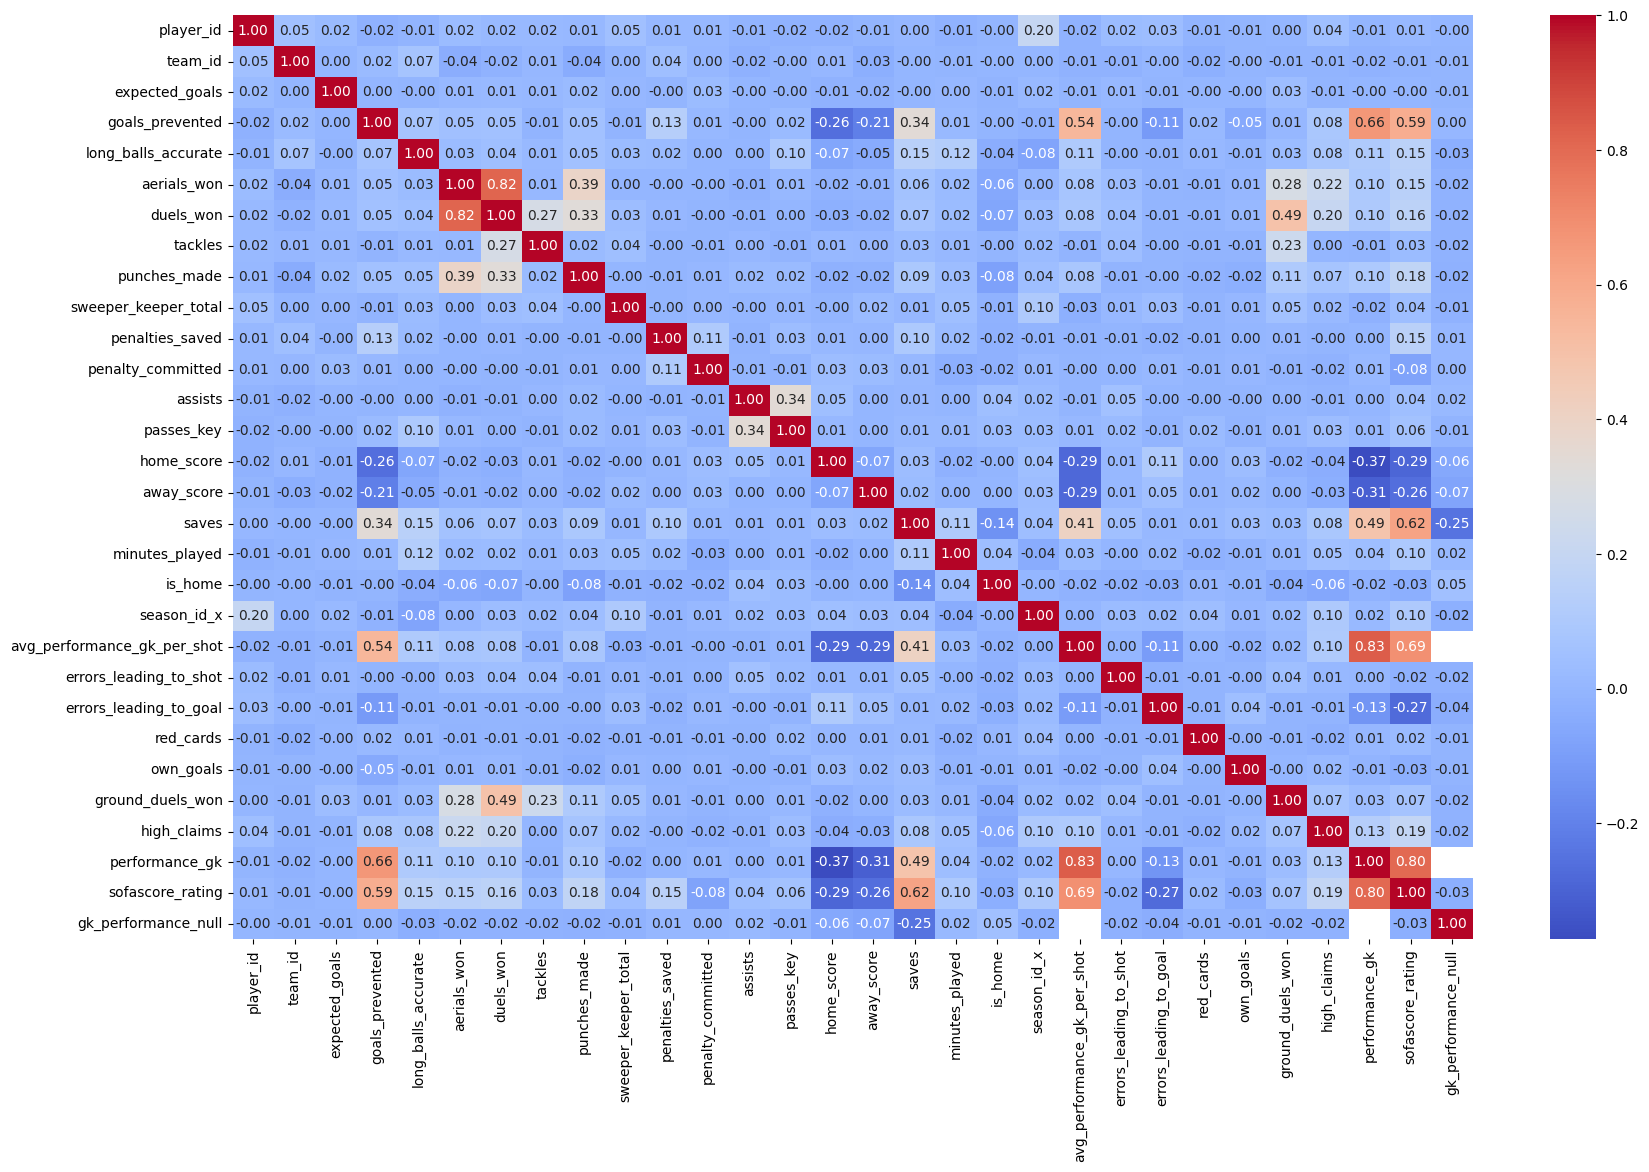

In [27]:
vars_analyze = ['player_id', 'team_id', 'expected_goals', 'goals_prevented', 'long_balls_accurate', 'aerials_won', 'duels_won', 'tackles', 'punches_made', 'sweeper_keeper_total','penalties_saved',
                 'penalty_committed', 'assists', 'passes_key', 'home_score', 'away_score', 'saves', 'minutes_played', 'is_home', 'season_id_x', 'avg_performance_gk_per_shot',
                 'errors_leading_to_shot', 'errors_leading_to_goal', 'red_cards', 'own_goals', 'ground_duels_won', 'high_claims','performance_gk', 'sofascore_rating',
                 'gk_performance_null']

#df_analyze = df_goalkeepers[vars_analyze].loc[~mask]
df_goalkeepers_clean = df_goalkeepers[vars_analyze]
plt.figure(figsize=(20,12))
sns.heatmap(df_goalkeepers_clean.corr(), annot=True, fmt = '2.2f', cmap='coolwarm')


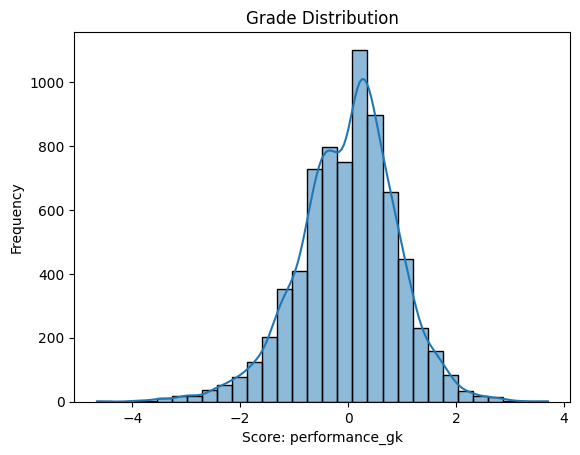

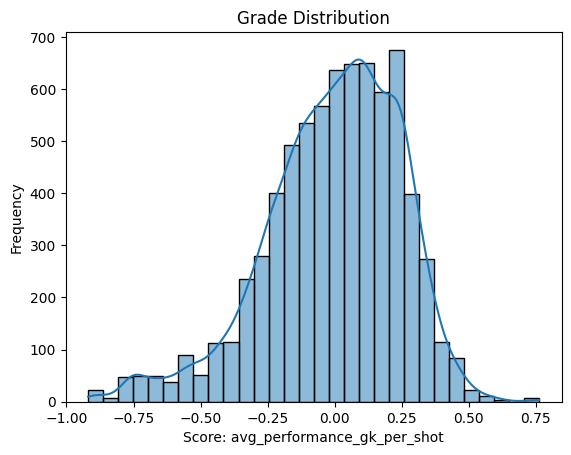

In [28]:
#df_goalkeepers_clean['performance_gk']

#gk_prior_scaling = df_goalkeepers_clean.groupby(['player_id'])['performance_gk'].mean().reset_index(name = 'performance_prior_scaling')

def hist_plot(df, col):

    sns.histplot(df[col], bins=30, kde=True)
    plt.title('Grade Distribution')
    plt.xlabel(f'Score: {col}')
    plt.ylabel('Frequency')
    plt.show()


hist_plot(df_goalkeepers_clean, 'performance_gk')
hist_plot(df_goalkeepers_clean, 'avg_performance_gk_per_shot')



Before scaling we are clipping the values in the following limits:
performance_gk: lower_lim: -3 & upper_lim: 2.
avg_performance_gk_per_shot: lower_lim: -0.75 & upper_lim: 0.6

The idea is setting some standard replicable. If we didnt apply this technique we wouldve have only one max score and one lowest score per df.


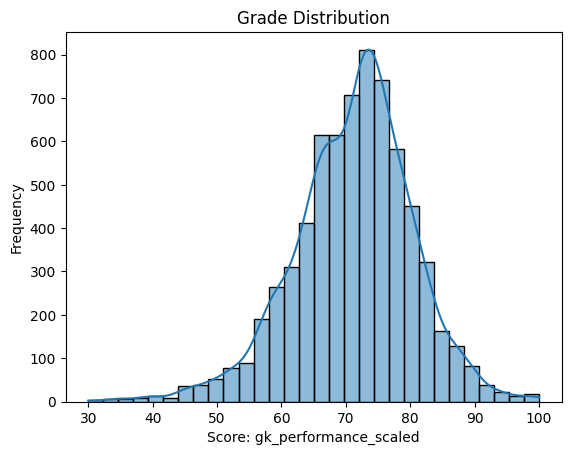

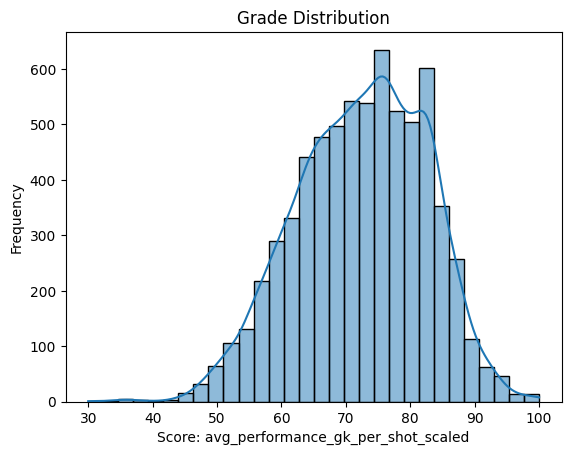

In [52]:
def scaling_performance(df, col, L, U, result: str):
    df1 = df.copy()
    
    df1[col] = df1[col].clip(upper = U)
    min_performance = df1[col].min()
    max_performance = df1[col].max()

    scale_min = 30
    scale_max = 100

    df1[result] = scale_min + (df1[col] - min_performance) * (scale_max - scale_min) / (max_performance - min_performance)

    hist_plot(df1, result)

    return df1 

filter_null_scoring =  (df_goalkeepers_clean['saves'] == 0) | (df_goalkeepers_clean['performance_gk'].isna())
df_goalkeepers_filtered = df_goalkeepers_clean.loc[~filter_null_scoring]

lower = df_goalkeepers_clean['performance_gk'].quantile(0.015)
higher = df_goalkeepers_clean['performance_gk'].quantile(0.999)
df_goalkeepers_scaled = scaling_performance(df_goalkeepers_filtered, col = 'performance_gk', L=lower, U = higher, result ='gk_performance_scaled')

lower_avg = df_goalkeepers_clean['avg_performance_gk_per_shot'].quantile(0.001)
higher_avg = df_goalkeepers_clean['avg_performance_gk_per_shot'].quantile(0.999)
df_goalkeepers_scaled2 = scaling_performance(df_goalkeepers_scaled,'avg_performance_gk_per_shot', L=lower_avg, U = higher_avg ,result = 'avg_performance_gk_per_shot_scaled')





In [ ]:
df_goalkeepers_scaled2.info()

Now That the value is scaled we can add the bonuses & penalties. This was really needed since we wanted to assign values based on domain knowledge. 
Now our metric is in a readable & interpretable scale we can do so.

In [61]:
def performance_bonusses_penalties(df, metric):
    df = df.copy()
    df = df.reset_index(drop=True) 
    bonus = {'penalties_saved': 15, 'assists': 15, 'key_passes': 5, 'clean_sheet': 1.25}
    penalties = {'errors_leading_to_goal': 15, 'errors_leading_to_shot': 4, 'penalty_committed': 15, 'red_cards': 20}
    anticipation = {'sweeper_keeper_total': 0.5, 'punches_made': 0.5, 'high_claims': 0.5, 'tackles': 0.75}

    for col, mult in bonus.items():
        
        if col in df.columns:
            df.loc[df[col] > 0, metric] += df[col] * mult


    if 'is_home' in df.columns and 'home_score' in df.columns and 'away_score' in df.columns:

        df.loc[(df['is_home'] == 1) & (df['away_score'] < 1), metric] *= bonus['clean_sheet']
        df.loc[(df['is_home'] == 0) & (df['home_score'] < 1), metric] *= bonus['clean_sheet']

    for col, mult in penalties.items():
        if col in df.columns:
            df.loc[df[col] > 0, metric] -= df[col] * mult

    if 'yellow_cards' in df.columns:
        df.loc[df['yellow_cards'] > 1, metric] -= df['yellow_cards'] * 10


    for col, mult in anticipation.items():
        if col in df.columns:
             df.loc[df[col] > 0, metric] += df[col] * mult


    return df



df_metric_completed = performance_bonusses_penalties(df_goalkeepers_scaled2, metric='gk_performance_scaled')
df_metric_completed = performance_bonusses_penalties(df_metric_completed, metric='avg_performance_gk_per_shot_scaled')

df_metric_completed[['home_score', 'away_score', 'goals_prevented', 'is_home','saves', 'sofascore_rating', 'gk_performance_scaled', 'avg_performance_gk_per_shot_scaled']].sort_values(by = 'sofascore_rating', ascending = False).head(25)




,home_score,away_score,goals_prevented,is_home,saves,sofascore_rating,gk_performance_scaled,avg_performance_gk_per_shot_scaled
3634,2,2,2.8159,0,11,10.0000,101.7134,85.3049
407,5,0,1.5883,1,10,9.8000,125.4122,106.2763
3852,0,1,1.3640,0,10,9.8000,118.8650,102.8966
3526,0,1,1.5261,0,7,9.7000,125.1072,114.1128
6352,4,2,1.7439,0,13,9.7000,92.9370,76.4440
4157,0,0,1.4528,0,9,9.6000,121.4478,105.9861
79,1,3,1.3347,1,12,9.6000,95.4509,89.8917
3847,0,2,3.2442,0,9,9.6000,144.7500,129.7202
6328,1,0,1.1711,0,10,9.5000,108.2178,97.8330
3345,0,1,3.3106,0,9,9.5000,106.0000,94.2219


In [65]:
def selecting_final_score(df):
    df1 = df.copy()
    df1['gk_performance_scaled'] = np.where(df1['gk_performance_scaled'] > 100, 100, df1['gk_performance_scaled'])
    df1['avg_performance_gk_per_shot_scaled'] = np.where(
        df1['avg_performance_gk_per_shot_scaled'] > 100, 100, df1['avg_performance_gk_per_shot_scaled']
    )

    # Seleccionar el máximo entre las dos métricas
    df1['final_metric'] = np.where(
        df1['gk_performance_scaled'] >= df1['avg_performance_gk_per_shot_scaled'],
        df1['gk_performance_scaled'],
        df1['avg_performance_gk_per_shot_scaled']
    )

    return df1


df_goalkeepers_full = selecting_final_score(df_metric_completed)


<Axes: >

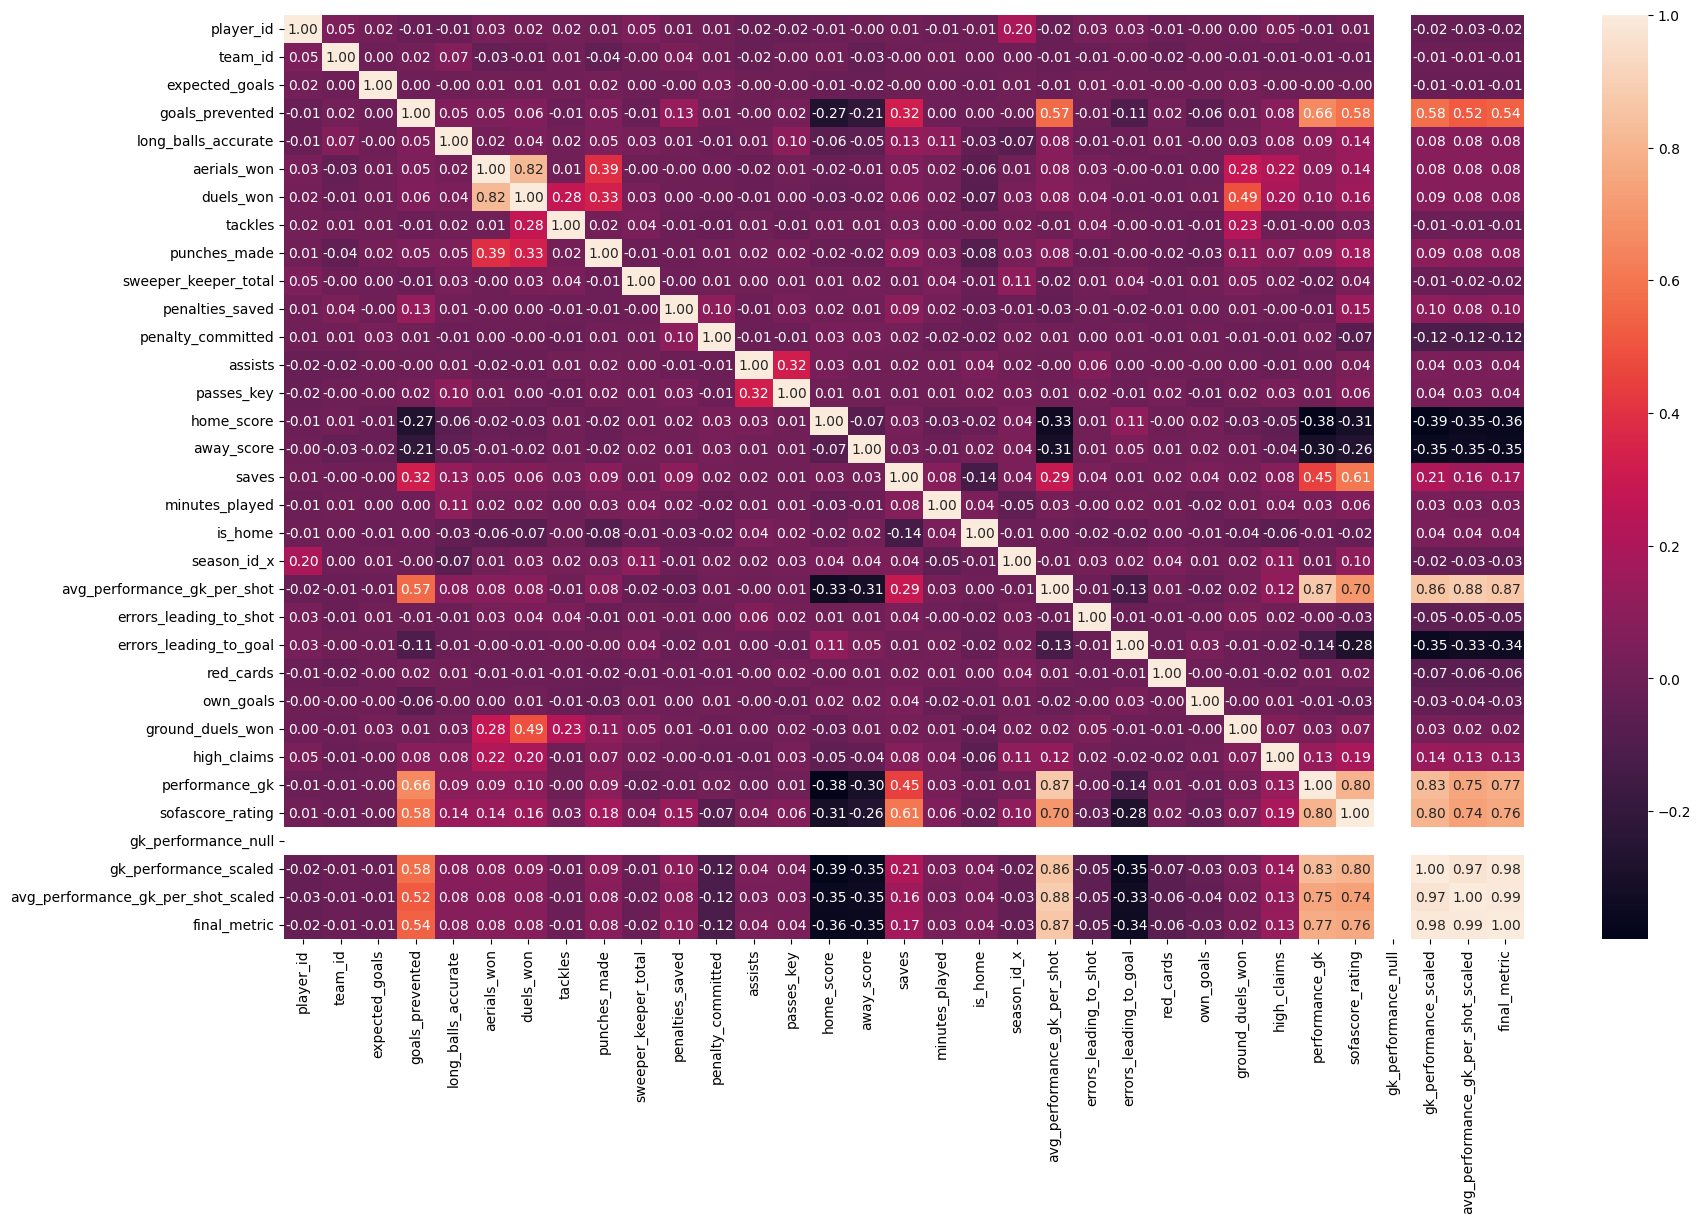

In [68]:
plt.figure(figsize = (20,12))
sns.heatmap(df_goalkeepers_full.corr(), annot = True, fmt = '2.2f')

In [70]:
performance_per_season = df_goalkeepers_full.groupby(['player_id', 'season_id_x']).agg(
    count_matches_per_season=('final_metric', 'count'),
    mean_performance_per_season=('final_metric', 'mean')
).reset_index()

players_performance = performance_per_season.merge(
    players[['player_id', 'name']],
    on='player_id',
    how='left'
)

order_performance = players_performance.sort_values(
    by=['mean_performance_per_season'],
    ascending=False
).reset_index(drop=True)


minimum_games_filter = order_performance['count_matches_per_season'] > 19

order_performance = order_performance.loc[minimum_games_filter]
order_performance.head(25)


,player_id,season_id_x,count_matches_per_season,mean_performance_per_season,name
12,88625,42409,35,89.4460,Marc-André ter Stegen
16,69768,32501,33,87.2689,Jan Oblak
17,254491,29415,29,87.0994,Ederson
19,243609,37036,32,86.5156,Alisson
25,791773,37223,30,84.9794,Álex Remiro
32,254491,37036,32,83.9819,Ederson
34,254491,52186,26,83.8747,Ederson
35,930997,52376,35,83.6529,Giorgi Mamardashvili
36,69768,61643,27,83.5928,Jan Oblak
37,360938,37223,29,83.5889,Bono


In [ ]:
sns.kdeplot(x='mean_performance_per_season', data =order_performance )

In [ ]:
maskx = order_performance['player_id'] == 70988
order_performance.loc[maskx]

In [ ]:
for col in away_gks.columns:
    print(col)

In [ ]:
#print("\nSample Final ELO Ratings:")
#final_elo_ratings.sort_values(by='final_elo', ascending=False).head()

In [ ]:
#final_elo_ratings.sort_values(by='final_elo', ascending=True).head()